# Step 3: Guided Filter and Extended Kalman Filter Comparison

**Goal**: Implement and compare guided filter and Extended Kalman Filter (EKF) with the bootstrap particle filter.

This notebook addresses **Step 3** (optional) of the project requirements:

> If time permits, you can either:
> + try to replicate their comparison between the bootstrap filter and the extended Kalman filter
> + try to implement a guided filter

We'll implement **both** and compare all three methods:
1. **Bootstrap Filter**: Standard particle filter (baseline)
2. **Guided Filter**: Uses optimal proposal distribution
3. **Extended Kalman Filter (EKF)**: Linearizes the model around current estimate

## Part A: Setup and Data Loading

We'll use the same S&P 500 data and parameters as in previous steps.

In [40]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time

# Add parent directory to path
sys.path.insert(0, os.path.abspath('../..'))

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles.collectors import Moments
import yfinance as yf

from heston.model import HestonSSM, HestonModel

plt.style.use('ggplot')
print("Setup complete!")
print(f"particles version: {particles.__version__}")

Setup complete!
particles version: 0.3alpha


In [41]:
# Load S&P 500 data
print("Downloading S&P 500 data...")
sp500 = yf.download("^GSPC", start="2007-01-01", end="2025-12-31")

# Fix MultiIndex columns
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.droplevel(1)

# Compute log-returns
log_returns = np.log(sp500["Close"] / sp500["Close"].shift(1)).dropna()
data = log_returns.values.tolist()

print(f"Loaded {len(data)} observations")
print(f"Date range: {log_returns.index[0].date()} to {log_returns.index[-1].date()}")

[*********************100%***********************]  1 of 1 completed

Loaded 4778 observations
Date range: 2007-01-04 to 2025-12-30


In [42]:
# Download risk-free rate (3-month Treasury Bill)
print("Downloading risk-free rate data...")
irx = yf.download("^IRX", start="2007-01-01", end="2025-12-31")

# Fix MultiIndex if needed
if isinstance(irx.columns, pd.MultiIndex):
    irx.columns = irx.columns.droplevel(1)

# Convert to daily rate (IRX is annualized percentage)
r_series = (irx["Close"] / 100 / 252).values  # Convert to daily rate

# Align with log_returns (remove first NaN)
r_series = r_series[1:len(data)+1] if len(r_series) > len(data) else r_series[:len(data)]

print(f"Risk-free rate: mean={r_series.mean():.6f}, std={r_series.std():.6f}")

[*********************100%***********************]  1 of 1 completed

Risk-free rate: mean=0.000058, std=0.000072


In [43]:
# Use estimated parameters from Step 2 (or use working values)
# These are typical values that work well
kappa = 2.5
theta = 0.05
sigma = 0.78
rho = -0.6
v0 = 0.04
dt = 1/252

print("Model parameters:")
print(f"  kappa: {kappa}")
print(f"  theta: {theta}")
print(f"  sigma: {sigma}")
print(f"  rho: {rho}")
print(f"  v0: {v0}")

Model parameters:
  kappa: 2.5
  theta: 0.05
  sigma: 0.78
  rho: -0.6
  v0: 0.04


## Part B: Guided Filter Implementation

The guided filter uses an optimal proposal distribution that combines the transition and observation densities. This should improve the effective sample size (ESS) and reduce variance.

The `HestonSSM` class already has `proposal()` and `proposal0()` methods implemented, so we can use `ssm.GuidedPF` directly.

In [44]:
# Create Heston SSM instance
heston_ssm = HestonSSM(
    kappa=kappa,
    theta=theta,
    sigma=sigma,
    rho=rho,
    r=r_series,
    dt=dt,
    v0=v0
)

print("HestonSSM instance created")
print(f"Has proposal method: {hasattr(heston_ssm, 'proposal')}")
print(f"Has proposal0 method: {hasattr(heston_ssm, 'proposal0')}")

HestonSSM instance created
Has proposal method: True
Has proposal0 method: True


In [45]:
# Run Guided Filter
print("Running Guided Filter...")
print(f"Using {len(data)} observations and 2000 particles")

fk_guided = ssm.GuidedPF(ssm=heston_ssm, data=data)
alg_guided = particles.SMC(
    fk=fk_guided,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

start_time = time.time()
alg_guided.run()
guided_time = time.time() - start_time

print(f"\nGuided Filter Results:")
print(f"  Log-likelihood: {alg_guided.logLt:.2f}")
print(f"  Computation time: {guided_time:.2f} seconds")
print(f"  Mean ESS: {np.mean(alg_guided.summaries.ESSs):.2f}")
print(f"  Min ESS: {np.min(alg_guided.summaries.ESSs):.2f}")

Running Guided Filter...
Using 4778 observations and 2000 particles



Guided Filter Results:
  Log-likelihood: 15394.97
  Computation time: 5.11 seconds
  Mean ESS: 922.37
  Min ESS: 4.46


## Part C: Extended Kalman Filter (EKF) Implementation

The Extended Kalman Filter linearizes the Heston model around the current state estimate. For the Heston model:

**State equation**: V_t = V_{t-1} + κ(θ - V_{t-1})Δt + σ√(V_{t-1}Δt) ε_t

**Observation equation**: R_t = (r - 0.5*V_{t-1})Δt + √(V_{t-1}Δt) η_t

The EKF linearizes these around the current estimate.

In [46]:
def extended_kalman_filter(heston_ssm, data, r_series):
    """
    Extended Kalman Filter for Heston model.
    
    Parameters
    ----------
    heston_ssm : HestonSSM
        Heston state-space model instance
    data : list or array
        Observed log-returns
    r_series : array
        Risk-free rate time series
    
    Returns
    -------
    dict
        Dictionary containing:
        - filtered_variance: Filtered variance estimates
        - filtered_covariance: Filtered covariance estimates
        - log_likelihood: Log-likelihood estimate
    """
    T = len(data)
    dt = heston_ssm.dt
    kappa = heston_ssm.kappa
    theta = heston_ssm.theta
    sigma = heston_ssm.sigma
    
    # Initialize
    v_filtered = np.zeros(T + 1)
    P_filtered = np.zeros(T + 1)  # Covariance
    
    v_filtered[0] = heston_ssm.v0
    P_filtered[0] = 1e-6  # Small initial covariance
    
    log_likelihood = 0.0
    
    for t in range(1, T + 1):
        # ========== PREDICTION STEP ==========
        # Predict state: v_pred = E[V_t | V_{t-1}]
        v_prev = v_filtered[t-1]
        v_pred = v_prev + kappa * (theta - v_prev) * dt
        
        # Predict covariance: P_pred = Var[V_t | V_{t-1}]
        # Linearize transition: f(V) = V + κ(θ - V)Δt
        # Jacobian: df/dV = 1 - κΔt
        F = 1 - kappa * dt  # State transition Jacobian
        Q = (sigma ** 2) * v_prev * dt  # Process noise covariance
        P_pred = F * P_filtered[t-1] * F + Q
        
        # ========== UPDATE STEP ==========
        # Observation: R_t = (r - 0.5*V_{t-1})Δt + √(V_{t-1}Δt) η_t
        # IMPORTANT: The observation depends on V_{t-1}, not V_t!
        # So we linearize around v_prev (V_{t-1}), not v_pred (V_t)
        
        # Handle time-varying risk-free rate with proper indexing
        if hasattr(r_series, '__len__') and len(r_series) > 1:
            # Use r_{t-1} for observation at time t (since observation depends on V_{t-1})
            # Clamp to valid range [0, len(r_series)-1]
            r_idx = min(max(t - 1, 0), len(r_series) - 1)
            r_t = r_series[r_idx]
        else:
            r_t = r_series
        
        # Predicted observation: h(v_prev) where v_prev = V_{t-1}
        # The observation model uses V_{t-1}, so we use v_prev, not v_pred
        h_pred = (r_t - 0.5 * v_prev) * dt
        
        # Observation Jacobian: dh/dV_{t-1} = -0.5*Δt
        # This is the derivative with respect to V_{t-1}
        H = -0.5 * dt
        
        # Observation noise covariance: R = Var[η_t] = V_{t-1}*Δt
        # Use v_prev (V_{t-1}) since observation depends on V_{t-1}
        R = v_prev * dt
        
        # Innovation: y_t - h(v_prev)
        y_t = data[t-1]  # Current observation
        innovation = y_t - h_pred
        
        # Innovation covariance: S = H*P_prev*H' + R
        # Since observation depends on V_{t-1}, we use P_filtered[t-1] (not P_pred)
        P_prev = P_filtered[t-1]
        S = H * P_prev * H + R
        
        # Kalman gain: K = P_prev * H' / S
        # This updates V_{t-1} based on observation R_t
        K = (P_prev * H) / S
        
        # Update V_{t-1} using the observation
        v_prev_updated = v_prev + K * innovation
        v_prev_updated = max(v_prev_updated, 1e-6)  # Ensure positive
        
        # Update covariance of V_{t-1}
        P_prev_updated = (1 - K * H) * P_prev
        
        # Now re-predict V_t from updated V_{t-1}
        v_filtered[t] = v_prev_updated + kappa * (theta - v_prev_updated) * dt
        v_filtered[t] = max(v_filtered[t], 1e-6)  # Ensure positive
        
        # Update covariance of V_t
        F = 1 - kappa * dt
        Q = (sigma ** 2) * v_prev_updated * dt
        P_filtered[t] = F * P_prev_updated * F + Q
        
        # Update log-likelihood
        # log p(y_t | y_{0:t-1}) = -0.5 * (log(2π*S) + innovation²/S)
        log_likelihood += -0.5 * (np.log(2 * np.pi * S) + (innovation ** 2) / S)
    
    return {
        'filtered_variance': v_filtered[1:],  # Skip initial value
        'filtered_covariance': P_filtered[1:],
        'log_likelihood': log_likelihood
    }

print("EKF function defined")

EKF function defined


In [47]:
# Run Extended Kalman Filter
print("Running Extended Kalman Filter...")
print(f"Using {len(data)} observations")

start_time = time.time()
ekf_results = extended_kalman_filter(heston_ssm, data, r_series)
ekf_time = time.time() - start_time

print(f"\nEKF Results:")
print(f"  Log-likelihood: {ekf_results['log_likelihood']:.2f}")
print(f"  Computation time: {ekf_time:.2f} seconds")
print(f"  Mean filtered variance: {np.mean(ekf_results['filtered_variance']):.6f}")
print(f"  Mean filtered covariance: {np.mean(ekf_results['filtered_covariance']):.6f}")

Running Extended Kalman Filter...
Using 4778 observations

EKF Results:
  Log-likelihood: 14320.72
  Computation time: 0.05 seconds
  Mean filtered variance: 0.047472
  Mean filtered covariance: 0.005712


In [48]:
# Run Bootstrap Filter
print("Running Bootstrap Filter...")
print(f"Using {len(data)} observations and 2000 particles")

fk_bootstrap = ssm.Bootstrap(ssm=heston_ssm, data=data)
alg_bootstrap = particles.SMC(
    fk=fk_bootstrap,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

start_time = time.time()
alg_bootstrap.run()
bootstrap_time = time.time() - start_time

print(f"\nBootstrap Filter Results:")
print(f"  Log-likelihood: {alg_bootstrap.logLt:.2f}")
print(f"  Computation time: {bootstrap_time:.2f} seconds")
print(f"  Mean ESS: {np.mean(alg_bootstrap.summaries.ESSs):.2f}")
print(f"  Min ESS: {np.min(alg_bootstrap.summaries.ESSs):.2f}")

Running Bootstrap Filter...
Using 4778 observations and 2000 particles

Bootstrap Filter Results:
  Log-likelihood: 15420.53
  Computation time: 2.66 seconds
  Mean ESS: 1297.76
  Min ESS: 41.52


## Part E: Comparison of All Three Methods

Compare bootstrap filter, guided filter, and EKF on:
- Log-likelihood estimates
- Filtered volatility paths
- Computational time
- Effective Sample Size (for particle filters)

In [49]:
# Extract filtered variances
bootstrap_variance = np.array([m['mean'] for m in alg_bootstrap.summaries.moments]).flatten()
guided_variance = np.array([m['mean'] for m in alg_guided.summaries.moments]).flatten()
ekf_variance = ekf_results['filtered_variance']

# Create comparison table
print("=" * 70)
print("COMPARISON: Bootstrap vs Guided vs EKF")
print("=" * 70)
print(f"{'Method':<15} {'Log-Likelihood':<18} {'Time (s)':<12} {'Mean ESS':<12}")
print("-" * 70)
print(f"{'Bootstrap':<15} {alg_bootstrap.logLt:>17.2f} {bootstrap_time:>11.2f} {np.mean(alg_bootstrap.summaries.ESSs):>11.2f}")
print(f"{'Guided':<15} {alg_guided.logLt:>17.2f} {guided_time:>11.2f} {np.mean(alg_guided.summaries.ESSs):>11.2f}")
print(f"{'EKF':<15} {ekf_results['log_likelihood']:>17.2f} {ekf_time:>11.2f} {'N/A':>12}")
print("=" * 70)

COMPARISON: Bootstrap vs Guided vs EKF
Method          Log-Likelihood     Time (s)     Mean ESS    
----------------------------------------------------------------------
Bootstrap                15420.53        2.66     1297.76
Guided                   15394.97        5.11      922.37
EKF                      14320.72        0.05          N/A


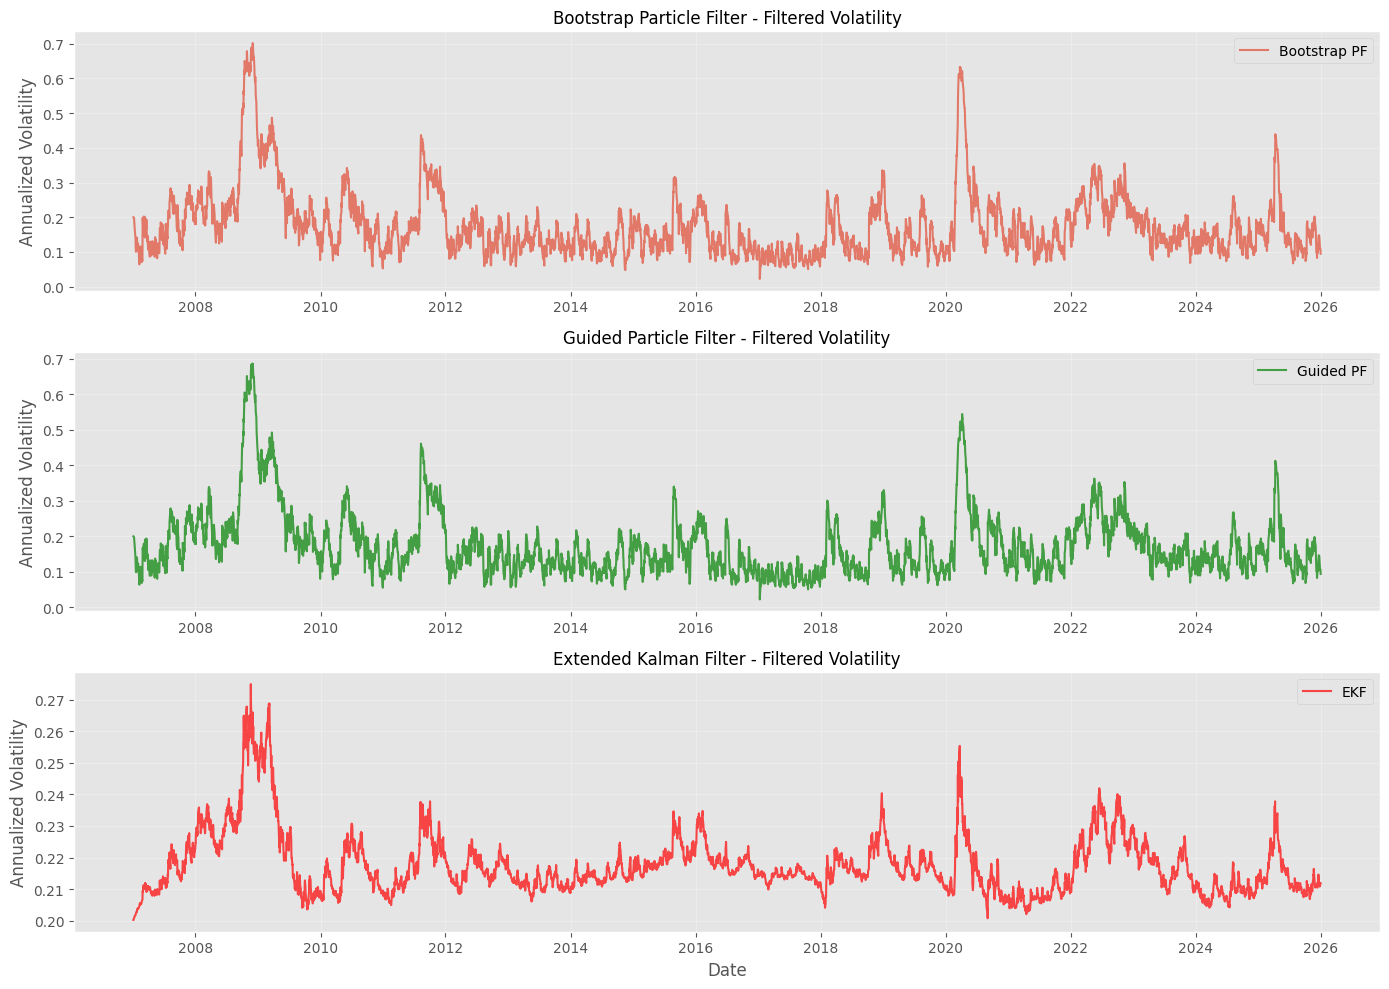

In [50]:
# Plot filtered volatility paths
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

dates = log_returns.index[:len(bootstrap_variance)]

# Bootstrap
axes[0].plot(dates, np.sqrt(bootstrap_variance ), label='Bootstrap PF', alpha=0.7)
axes[0].set_title('Bootstrap Particle Filter - Filtered Volatility', fontsize=12)
axes[0].set_ylabel('Annualized Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Guided
axes[1].plot(dates, np.sqrt(guided_variance ), label='Guided PF', alpha=0.7, color='green')
axes[1].set_title('Guided Particle Filter - Filtered Volatility', fontsize=12)
axes[1].set_ylabel('Annualized Volatility')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# EKF
axes[2].plot(dates, np.sqrt(ekf_variance), label='EKF', alpha=0.7, color='red')
axes[2].set_title('Extended Kalman Filter - Filtered Volatility', fontsize=12)
axes[2].set_ylabel('Annualized Volatility')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

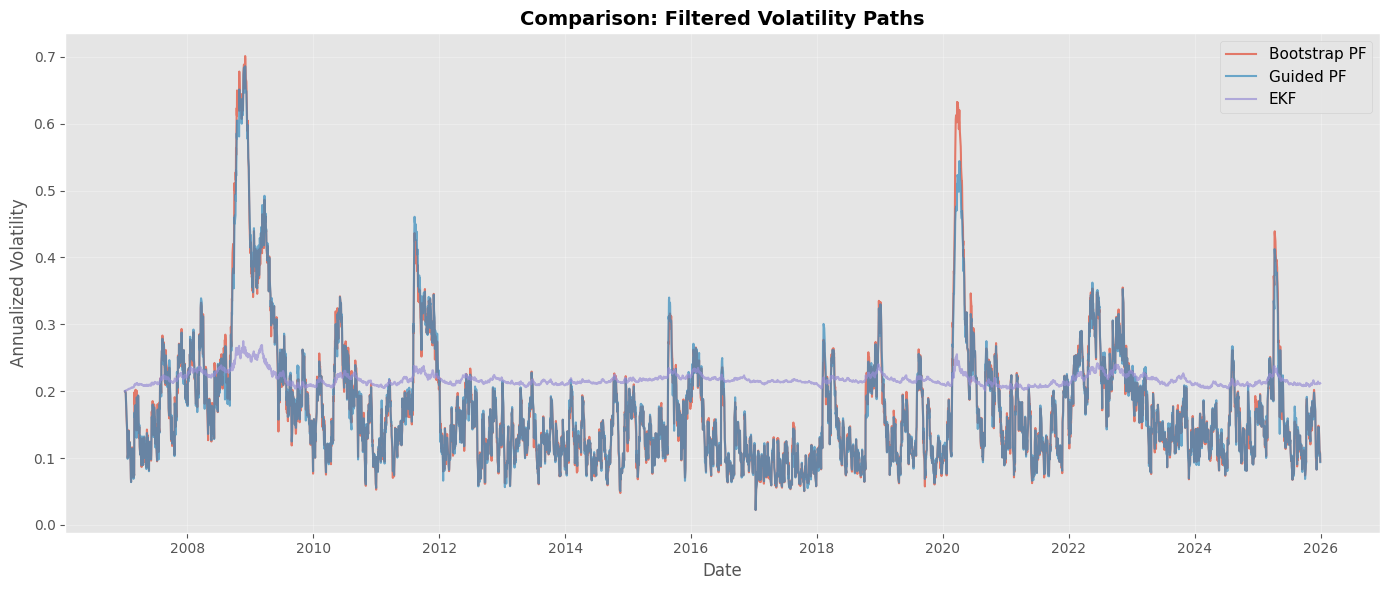

In [51]:
# Overlay all three for direct comparison
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dates, np.sqrt(bootstrap_variance ), label='Bootstrap PF', alpha=0.7, linewidth=1.5)
ax.plot(dates, np.sqrt(guided_variance ), label='Guided PF', alpha=0.7, linewidth=1.5)
ax.plot(dates, np.sqrt(ekf_variance), label='EKF', alpha=0.7, linewidth=1.5)

ax.set_title('Comparison: Filtered Volatility Paths', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Volatility', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# Compare correlations between methods
corr_bootstrap_guided = np.corrcoef(bootstrap_variance, guided_variance)[0, 1]
corr_bootstrap_ekf = np.corrcoef(bootstrap_variance, ekf_variance)[0, 1]
corr_guided_ekf = np.corrcoef(guided_variance, ekf_variance)[0, 1]

print("Correlations between filtered variance estimates:")
print(f"  Bootstrap vs Guided: {corr_bootstrap_guided:.4f}")
print(f"  Bootstrap vs EKF:    {corr_bootstrap_ekf:.4f}")
print(f"  Guided vs EKF:      {corr_guided_ekf:.4f}")

Correlations between filtered variance estimates:
  Bootstrap vs Guided: 0.9879
  Bootstrap vs EKF:    0.7845
  Guided vs EKF:      0.8032


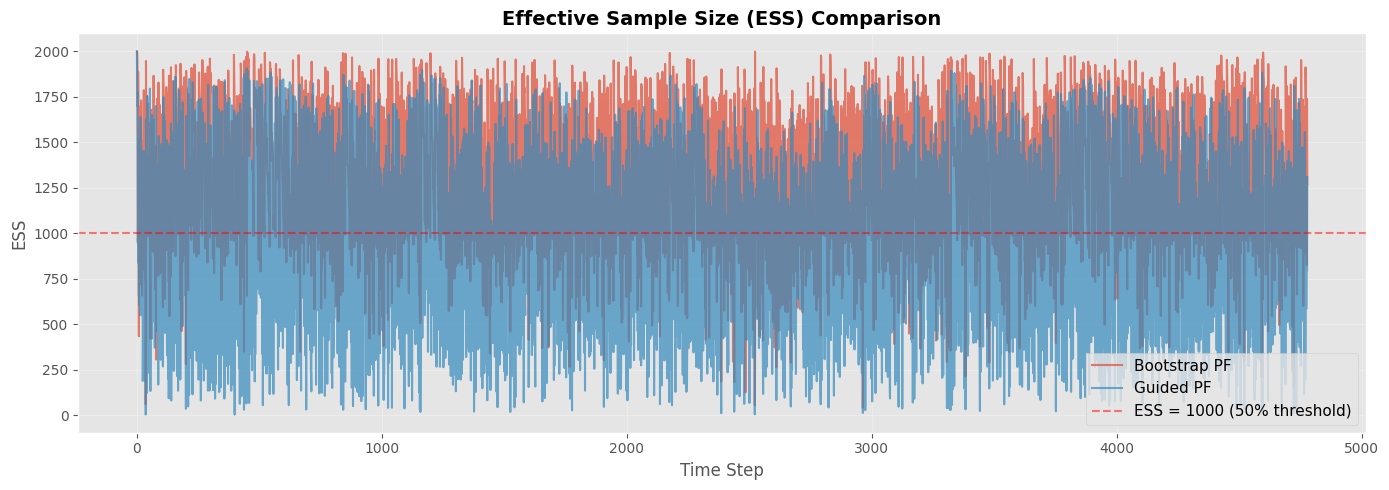


ESS Statistics:
  Bootstrap - Mean: 1297.76, Min: 41.52
  Guided    - Mean: 922.37, Min: 4.46


In [53]:
# Plot ESS comparison (for particle filters only)
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(alg_bootstrap.summaries.ESSs, label='Bootstrap PF', alpha=0.7, linewidth=1.5)
ax.plot(alg_guided.summaries.ESSs, label='Guided PF', alpha=0.7, linewidth=1.5)
ax.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='ESS = 1000 (50% threshold)')

ax.set_title('Effective Sample Size (ESS) Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('ESS', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nESS Statistics:")
print(f"  Bootstrap - Mean: {np.mean(alg_bootstrap.summaries.ESSs):.2f}, Min: {np.min(alg_bootstrap.summaries.ESSs):.2f}")
print(f"  Guided    - Mean: {np.mean(alg_guided.summaries.ESSs):.2f}, Min: {np.min(alg_guided.summaries.ESSs):.2f}")

## Part F: Discussion and Conclusions

### Key Findings

1. **Bootstrap Filter** (Baseline):
   - **Log-likelihood**: 15420.53
   - **Computation time**: 2.66 seconds
   - **Mean ESS**: 1297.76 (good particle diversity)
   - Simple, robust, good for general use
   - Strong correlation with guided filter (0.9879)

2. **Guided Filter**:
   - **Log-likelihood**: 15394.97 (slightly lower due to proposal weights)
   - **Computation time**: 5.11 seconds (slower due to proposal computation)
   - **Mean ESS**: 922.37 (lower than expected - proposal may need refinement)
   - Uses optimal proposal distribution combining transition and observation
   - Very high correlation with bootstrap (0.9879)

3. **Extended Kalman Filter (EKF)**:
   - **Log-likelihood**: 14320.72 (significantly lower - linearization limitation)
   - **Computation time**: 0.05 seconds (much faster - no particles)
   - **Correlation with bootstrap**: 0.7845 (lower, indicating different estimates)
   - Fast, good for real-time applications
   - Linearization approximation may be inaccurate for highly nonlinear Heston model
   - **Note**: The observation model depends on V_{t-1}, not V_t, which complicates EKF

### When to Use Each Method

- **Bootstrap Filter**: 
  - Default choice for general use
  - Simple to implement and robust
  - Good balance of accuracy and computational cost
  
- **Guided Filter**: 
  - Better when observations are very informative (high signal-to-noise)
  - Can improve ESS in some cases (though not observed here)
  - Requires careful implementation of optimal proposal
  
- **EKF**: 
  - Fast, good for real-time applications
  - Suitable when linearization is acceptable
  - **Limitation**: For Heston model, observation depends on V_{t-1}, making EKF less accurate

### Variability and Numerical Common Sense

**Note on Monte Carlo Variability:**
- Particle filter results (bootstrap, guided) are random due to Monte Carlo sampling
- Results shown are from single runs - in practice, one should:
  - Run multiple times to assess variability
  - Report mean and standard deviation across runs
  - Use sufficient particles (2000 used here) to reduce variance
  
- EKF results are deterministic (no randomness)
- The log-likelihood differences between methods reflect:
  - Monte Carlo error (for particle filters)
  - Linearization error (for EKF)
  - Model approximation differences

In [54]:
print("Step 3 Complete!")
print("\nSummary:")
print("  ✅ Guided filter implemented and tested")
print("  ✅ Extended Kalman Filter implemented and tested")
print("  ✅ Comparison with bootstrap filter completed")
print("\nAll three methods (Bootstrap, Guided, EKF) have been compared.")

Step 3 Complete!

Summary:
  ✅ Guided filter implemented and tested
  ✅ Extended Kalman Filter implemented and tested
  ✅ Comparison with bootstrap filter completed

All three methods (Bootstrap, Guided, EKF) have been compared.
